In [65]:
import json
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy.stats
import pandas as pd
%matplotlib inline
plt.rcParams["figure.dpi"] = 150
BASE_PATH = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'results'))
OUTPUT_PATH = os.path.abspath(os.path.join(os.getcwd(), 'figures'))

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [66]:
# Adapted from https://towardsdatascience.com/making-matplotlib-beautiful-by-default-d0d41e3534fd
sns.set(font='Helvetica',
        rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'None',
 'axes.grid': True,
 'axes.axisbelow': True,
 'grid.color': 'lightgrey',
 'axes.labelcolor': 'dimgrey',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'dimgrey',
 'xtick.bottom': False,
 'xtick.color': 'dimgrey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'dimgrey',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})
sns.set_context("notebook", rc={"font.size":14,
                                "axes.titlesize":16,
                                "axes.labelsize":13})

In [3]:
def parse_json(path):
    data = {}
    for f in os.listdir(path):
        lambda_no = 1
        has_multiple_lambda = False
        matches_multiple_lambda = re.search(r"(producer|consumer)_(\d+)_(\d+)_(\d+).json", f)
        if matches_multiple_lambda:
            lambda_no = int(matches_multiple_lambda.group(4))
            has_multiple_lambda = True
            matches = matches_multiple_lambda
        else:
            matches = re.search(r"(producer|consumer)_(\d+)_(\d+).json", f)
        if matches:
            run_type, file_size, run = matches.group(1), int(matches.group(2)), int(matches.group(3))
            if run_type not in data:
                data[run_type] = {}
            if file_size not in data[run_type]:
                data[run_type][file_size] = {}
            if has_multiple_lambda and run not in data[run_type][file_size]:
                data[run_type][file_size][run] = {}
            with open(os.path.join(path, f)) as file_p:
                json_data = json.load(file_p)
                if has_multiple_lambda:
                    data[run_type][file_size][run][lambda_no] = json_data
                else:
                    data[run_type][file_size][run] = json_data
    return data

def calc_deltas(data):
    deltas = {}
    for file_size, runs in data['consumer'].items():
        deltas[file_size] = {}
        for run_number, run_data in runs.items():
            if 'finishedTime' in run_data: # single lambda
                if int(np.log10(run_data['finishedTime'])) == 15:
                    # Convert to ms
                    run_data['finishedTime'] /= 1000
                    data['producer'][file_size][run_number]['uploadTime'] /= 1000
                if run_data['finishedTime'] - data['producer'][file_size][run_number]['uploadTime'] < 0.1:
                    deltas[file_size][run_number] = 0.1
                else:
                    deltas[file_size][run_number] = run_data['finishedTime'] - data['producer'][file_size][run_number]['uploadTime']
                
            else:
                all_finished_times = [lambda_run['finishedTime'] for lambda_run in run_data.values()]
                if int(np.log10(data['producer'][file_size][run_number]['uploadTime'])) == 15:
                    data['producer'][file_size][run_number]['uploadTime'] /= 1000
                    all_finished_times = [v / 1000 for v in all_finished_times]
                all_deltas = []
                for fin_time in all_finished_times:
                    if fin_time - data['producer'][file_size][run_number]['uploadTime'] < 0:
                        all_deltas.append(0.1)
                    else:
                        all_deltas.append(fin_time - data['producer'][file_size][run_number]['uploadTime'])

                deltas[file_size][run_number] = all_deltas
    return deltas

In [4]:
def format_xticks(label_values):
    xticks = []
    for val in label_values:
        if val == 10000:
            xticks.append("10⁴")
        elif val == 100000:
            xticks.append("10⁵")
        elif val == 500000:
            xticks.append("5·10⁵")
        elif val >= 1:
            xticks.append(str(int(val)))
        else:
            xticks.append(str(val))
    return xticks

## Data

In [7]:
DIRECT_BASE_PATH = os.path.join(BASE_PATH, 'smi', 'out_lambda_direct')
REDIS_BASE_BATH = os.path.join(BASE_PATH, 'smi', 'out_lambda_redis')
S3_BASE_BATH = os.path.join(BASE_PATH, 'smi', 'out_lambda_s3')
experiments = ['allreduce', 'bcast', 'gather', 'reduce', 'scan', 'scatter']

vals = {}
NUM_NODES = [2, 4, 8, 16, 32, 64, 128, 256]
for experiment in experiments:
    data = {"n": [], "latency": [], "method": []}
    for num_node in NUM_NODES:
        for base_path, channel in [(DIRECT_BASE_PATH, "Direct"), (REDIS_BASE_BATH, "Redis"), (S3_BASE_BATH, "S3")]:
            if num_node > 32 and channel == "S3":
                continue
            if num_node > 64 and channel == "Redis":
                continue
            res_rounds = {}
            start_times = {}
            for i in range(num_node):
                path = os.path.join(base_path, "{}_{}_{}.json".format(experiment, num_node, i))
                with open(path) as file:
                    lines = file.readlines()
                    for line in lines:
                        parts = line.rstrip().split(",")
                        peer_id = int(parts[0])
                        exchange_num = int(parts[1])
                        val = int(parts[2])
                        if peer_id == 0:
                            start_times[exchange_num] = val
                        else:
                            if exchange_num not in res_rounds:
                                res_rounds[exchange_num] = [val]
                            else:
                                res_rounds[exchange_num].append(val)
            for exchange_num, values in res_rounds.items():
                data["n"].append(num_node)
                if experiment == "gather":
                    data["latency"].append(start_times[exchange_num] - min(values))
                else:
                    data["latency"].append(max(values) - start_times[exchange_num])
                data["method"].append(channel)
        vals[experiment] = pd.DataFrame(data)

for experiment in experiments:
    print(experiment)
    display(vals[experiment].groupby(['n', 'method']).mean())
lambda_bench = vals

allreduce


latency
n   method               
2   Direct    1040.533333
    Redis     4645.100000
    S3      108971.800000
4   Direct    2323.066667
    Redis     8236.733333
    S3      156254.700000
8   Direct    3995.766667
    Redis    12021.733333
    S3      285996.700000
16  Direct    5022.800000
    Redis    27981.633333
    S3      369697.400000
32  Direct   10028.900000
    Redis    51662.566667
    S3      600348.600000
64  Direct   11236.866667
    Redis   230199.333333
128 Direct   22931.033333
256 Direct   53593.300000

bcast


latency
n   method              
2   Direct    998.200000
    Redis    1911.600000
    S3      42280.400000
4   Direct    778.466667
    Redis    2735.133333
    S3      49379.600000
8   Direct   1028.500000
    Redis    2823.900000
    S3      67196.900000
16  Direct   2632.400000
    Redis    4125.833333
    S3      59371.900000
32  Direct   3220.166667
    Redis   12316.466667
    S3      95567.000000
64  Direct   4896.966667
    Redis   40465.900000
128 Direct   8306.700000
256 Direct  26570.733333

gather


latency
n   method               
2   Direct     719.800000
    Redis     1987.433333
    S3       56301.000000
4   Direct    1185.033333
    Redis     4425.533333
    S3       99532.700000
8   Direct    2460.566667
    Redis    10478.233333
    S3      178098.100000
16  Direct    3151.433333
    Redis    17681.900000
    S3      380872.600000
32  Direct    4949.933333
    Redis    39745.400000
    S3      598314.500000
64  Direct   11728.600000
    Redis   147251.600000
128 Direct    9366.133333
256 Direct   20237.166667

reduce


latency
n   method               
2   Direct     495.500000
    Redis     1781.566667
    S3       36746.400000
4   Direct     979.100000
    Redis     1786.466667
    S3       32523.500000
8   Direct    2050.133333
    Redis     3217.400000
    S3       46436.500000
16  Direct    3461.433333
    Redis     6889.033333
    S3       60714.900000
32  Direct    6494.266667
    Redis    25463.566667
    S3      105501.400000
64  Direct    6451.100000
    Redis    40859.966667
128 Direct    9404.133333
256 Direct   16532.900000

scan


latency
n   method               
2   Direct     757.666667
    Redis     3168.333333
    S3       61062.100000
4   Direct    1062.466667
    Redis     5195.933333
    S3      112032.400000
8   Direct    1509.266667
    Redis     9788.366667
    S3      168780.800000
16  Direct    3595.466667
    Redis    16778.400000
    S3      265502.100000
32  Direct    5369.200000
    Redis    40565.166667
    S3      513525.100000
64  Direct    8179.600000
    Redis   184719.200000
128 Direct   12221.000000
256 Direct   28415.533333

scatter


latency
n   method               
2   Direct     127.400000
    Redis     2402.333333
    S3       58608.500000
4   Direct     939.800000
    Redis     4393.766667
    S3      114011.400000
8   Direct    2007.533333
    Redis     8188.666667
    S3      276568.800000
16  Direct    3777.266667
    Redis    14803.966667
    S3      484673.800000
32  Direct    3712.066667
    Redis    36371.566667
    S3      922380.300000
64  Direct    7779.700000
    Redis   123478.600000
128 Direct   15899.200000
256 Direct   19221.333333

## FMI Benchmarks

'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


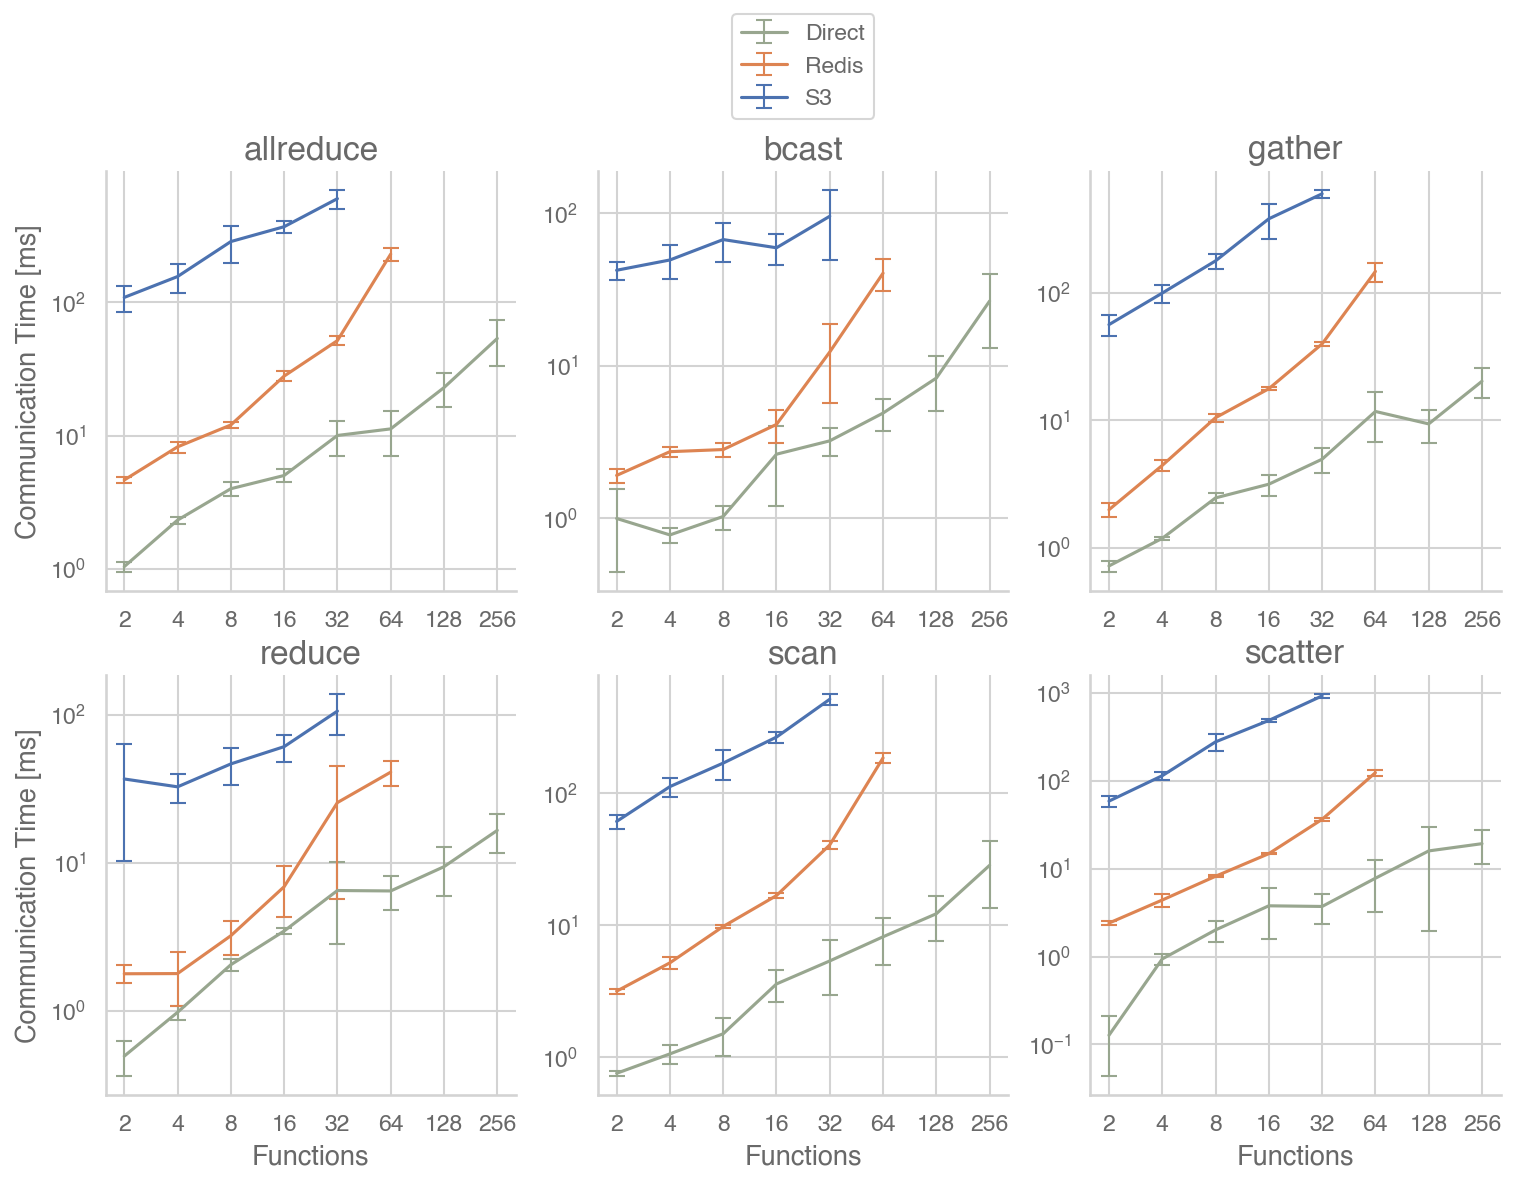

In [9]:

my_pal = {
    "Redis": "C1", 
    "Direct": "#98a68f", 
    "S3": "C0"
}
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
for method in ["Direct", "Redis", "S3"]:
    ix, iy = 0, 0
    for experiment in experiments:
        plot_data = {}
        error = []
        preds = {}
        for num_node in NUM_NODES:
            if num_node > 32 and method == "S3":
                continue
            if num_node > 64 and method == "Redis":
                continue
            experiment_sizes = {
                "allreduce": 4,
                "bcast": 4,
                "gather": 4992 / num_node,
                "reduce": 4,
                "scan": 4,
                "scatter": 4992 / num_node
            }
            #model_pred = get_model_op_latency(num_node, method, experiment, experiment_sizes[experiment])
            #preds[num_node] = model_pred
            values = vals[experiment].loc[(vals[experiment]['n'] == num_node) & (vals[experiment]['method'] == method)]['latency']
            mean = np.mean(values)
            ci = scipy.stats.sem(values) * scipy.stats.t.ppf((1 + 0.95) / 2., len(values) - 1)
            plot_data[num_node] = mean / 1000
            error.append(ci / 1000)
        axs[ix,iy].errorbar(plot_data.keys(), plot_data.values(), error, elinewidth=1, capsize=4, label=method, c=my_pal[method])
        axs[ix,iy].scatter(preds.keys(), preds.values(), marker="X", c=my_pal[method])
        axs[ix,iy].set_title(experiment)
        axs[ix,iy].set_yscale('log')
        axs[ix,iy].set_xscale('log')
        axs[ix,iy].set_xticks(NUM_NODES)
        axs[ix,iy].set_xticklabels(NUM_NODES)
        if ix == 0 and iy == 1:
            axs[ix,iy].legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), fancybox=True)
        else:
            axs[ix,iy].legend([],[], frameon=False)
        if ix == 1:
            axs[ix,iy].set_xlabel("Functions")
        else:
            axs[ix,iy].set_xlabel(None)
        if iy == 0:
            axs[ix,iy].set_ylabel("Communication Time [ms]")
        else:
            axs[ix,iy].set_ylabel(None)
        iy += 1
        if iy > 2:
            iy = 0
            ix = 1
fig.savefig(os.path.join(OUTPUT_PATH, "fmi_benchmark_collectives.pdf"), bbox_inches='tight')

## New data

In [89]:

BASE_PATH = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
DIRECT_BASE_PATH = os.path.join(BASE_PATH, 'fmi', 'out_tcp')
REDIS_BASE_BATH = os.path.join(BASE_PATH, 'fmi', 'out_redis')
S3_BASE_BATH = os.path.join(BASE_PATH, 'fmi', 'out_s3')
experiments = ['allreduce', 'bcast', 'gather', 'reduce', 'scan', 'scatter']

NUM_NODES = [2, 4, 8, 16, 32, 64, 128]

s3_data = []
for experiment in experiments:
    for num_node in NUM_NODES:
        
        dfs = []
        for rank in range(num_node):
                          
            mpi_path = os.path.join(S3_BASE_BATH, f"{experiment}_{num_node}_{rank}.json")
            
            data = pd.read_csv(mpi_path, names=['peer', 'idx', 'start', 'end', 'duration', 'retries'])[1:101]
            data.reset_index(inplace=True)
            dfs.append(data)
            #data['size'] = num_node
            #data['ranks'] = num_node
            #data['experiment'] = experiment
            #print(data)
        data = pd.concat(dfs)
        #print(data)
        max_data = data.groupby(['idx'])['duration'].max().reset_index()
        max_data['ranks'] = num_node
        max_data['experiment'] = experiment
        #print(max_data)
        s3_data.append(max_data)
        
s3_data = pd.concat(s3_data)
s3_data["method"] = "S3"

redis_data = []
for experiment in experiments:
    for num_node in NUM_NODES:
        
        dfs = []
        for rank in range(num_node):
                          
            mpi_path = os.path.join(REDIS_BASE_BATH, f"{experiment}_{num_node}_{rank}.json")
            
            data = pd.read_csv(mpi_path, names=['peer', 'idx', 'start', 'end', 'duration', 'retries'])[1:101]
            data.reset_index(inplace=True)
            dfs.append(data)
            #data['size'] = num_node
            #data['ranks'] = num_node
            #data['experiment'] = experiment
            #print(data)
        data = pd.concat(dfs)
        #print(data)
        max_data = data.groupby(['idx'])['duration'].max().reset_index()
        max_data['ranks'] = num_node
        max_data['experiment'] = experiment
        #print(max_data)
        redis_data.append(max_data)
        
redis_data = pd.concat(redis_data)
redis_data["method"] = "Redis"

tcp_data = []
NUM_NODES = [2, 4, 8, 16, 32, 64, 128, 256]
for experiment in experiments:
    for num_node in NUM_NODES:
        
        dfs = []
        for rank in range(num_node):
                          
            for rep in range(30):
                mpi_path = os.path.join(DIRECT_BASE_PATH, f"{experiment}_{num_node}_{rank}_{rep+1}.json")
                #print(mpi_path)
                data = pd.read_csv(mpi_path, names=['peer', 'idx', 'start', 'end', 'duration', 'retries'])[1:]
                data['idx'] = rep
                data.reset_index(inplace=True)
                dfs.append(data)
            #data['size'] = num_node
            #data['ranks'] = num_node
            #data['experiment'] = experiment
            #print(data)
        data = pd.concat(dfs)
        #print(data)
        #print(data)
        max_data = data.groupby(['idx'])['duration'].max().reset_index()
        max_data['ranks'] = num_node
        max_data['experiment'] = experiment
        #print(max_data)
        tcp_data.append(max_data)
        
tcp_data = pd.concat(tcp_data)
tcp_data["method"] = "Direct"

data = pd.concat([s3_data, redis_data, tcp_data])


In [84]:
tcp_data = []
#NUM_NODES = [2, 4, 8, 16, 32, 64, 128]
NUM_NODES = [32]
for experiment in experiments:
    for num_node in NUM_NODES:
        
        dfs = []
        for rank in range(num_node):
                          
            for rep in range(30):
                mpi_path = os.path.join(DIRECT_BASE_PATH, f"{experiment}_{num_node}_{rank}_{rep+1}.json")
                #print(mpi_path)
                data = pd.read_csv(mpi_path, names=['peer', 'idx', 'start', 'end', 'duration', 'retries'])[1:]
                data['idx'] = rep
                data.reset_index(inplace=True)
                dfs.append(data)
            #data['size'] = num_node
            #data['ranks'] = num_node
            #data['experiment'] = experiment
            #print(data)
        data = pd.concat(dfs)
        #print(data)
        #print(data)
        max_data = data.groupby(['idx'])['duration'].max().reset_index()
        max_data['ranks'] = num_node
        max_data['experiment'] = experiment
        #print(max_data)
        tcp_data.append(max_data)
        
tcp_data = pd.concat(tcp_data)
tcp_data["method"] = "Direct"

data = pd.concat([s3_data, redis_data, tcp_data])
print(tcp_data)

    idx  duration  ranks experiment  method
0     0      5556     32  allreduce  Direct
1     1      7795     32  allreduce  Direct
2     2      4230     32  allreduce  Direct
3     3      5901     32  allreduce  Direct
4     4      5284     32  allreduce  Direct
..  ...       ...    ...        ...     ...
25   25      2006     32    scatter  Direct
26   26      1366     32    scatter  Direct
27   27       865     32    scatter  Direct
28   28      1324     32    scatter  Direct
29   29      3438     32    scatter  Direct

[180 rows x 5 columns]


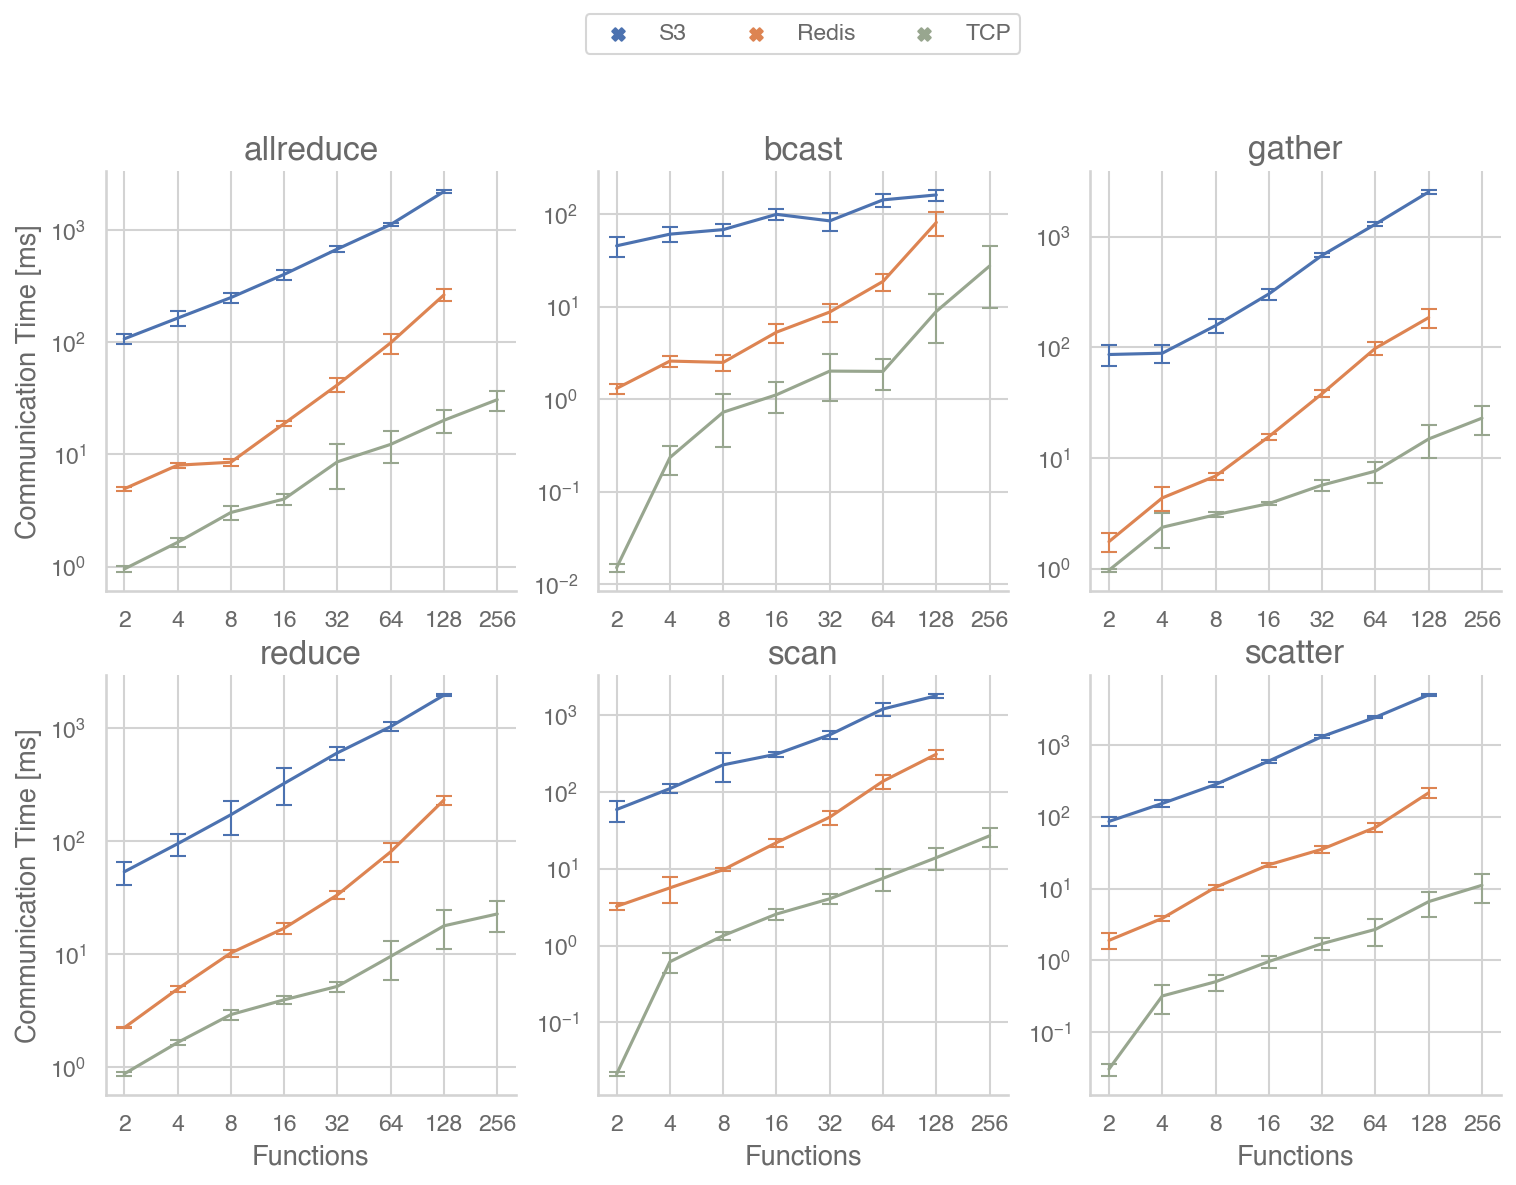

In [93]:

my_pal = {
    "Redis": "C1", 
    "Direct": "#98a68f", 
    "S3": "C0"
}
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

NUM_NODES = [2, 4, 8, 16, 32, 64, 128, 256]
#for method in ["Direct", "Redis", "S3"]:
for method in ["S3", "Redis", "Direct"]:
#for method in ["S3", "Redis"]:
    ix, iy = 0, 0
    for experiment in experiments:
        plot_data = {}
        error = []
        preds = {}
        for num_node in NUM_NODES:
            if num_node > 128 and method == "S3":
                continue
            if num_node > 128 and method == "Redis":
                continue
            if num_node > 256 and method == "Direct":
                continue
            experiment_sizes = {
                "allreduce": 4,
                "bcast": 4,
                "gather": 5000 / num_node,
                "reduce": 4,
                "scan": 4,
                "scatter": 5000 / num_node
            }
            #model_pred = get_model_op_latency(num_node, method, experiment, experiment_sizes[experiment])
            #preds[num_node] = model_pred
            #values = vals[experiment].loc[(vals[experiment]['n'] == num_node) & (vals[experiment]['method'] == method)]['latency']
            values = data.loc[
                (data['experiment'] == experiment) & (data['ranks'] == num_node)
                & (data['method'] == method)
            ]['duration']
            mean = np.mean(values)
            ci = scipy.stats.sem(values) * scipy.stats.t.ppf((1 + 0.95) / 2., len(values) - 1)
            plot_data[num_node] = mean / 1000
            error.append(ci / 1000)
            
        #print(method, values)
        axs[ix,iy].errorbar(plot_data.keys(), plot_data.values(), error, elinewidth=1, capsize=4, label=method, c=my_pal[method])
        axs[ix,iy].scatter(preds.keys(), preds.values(), marker="X", c=my_pal[method])
        axs[ix,iy].set_title(experiment)
        axs[ix,iy].set_yscale('log')
        axs[ix,iy].set_xscale('log')
        #axs[ix,iy].set_xlim(2, 64)
        axs[ix,iy].set_xticks(NUM_NODES)
        axs[ix,iy].set_xticklabels(NUM_NODES)
        if ix == 0 and iy == 1:
            axs[ix,iy].legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=3, labels=["S3", "Redis", "TCP"], fancybox=True)
        else:
            axs[ix,iy].legend([],[], frameon=False)
        if ix == 1:
            axs[ix,iy].set_xlabel("Functions")
        else:
            axs[ix,iy].set_xlabel(None)
        if iy == 0:
            axs[ix,iy].set_ylabel("Communication Time [ms]")
        else:
            axs[ix,iy].set_ylabel(None)
        iy += 1
        if iy > 2:
            iy = 0
            ix = 1
#fig.savefig(os.path.join(OUTPUT_PATH, "fmi_benchmark_collectives.pdf"), bbox_inches='tight')

In [73]:
print(redis_data[(redis_data['experiment'] == 'scan') & (redis_data['ranks'] == 128)])

    idx  duration  ranks experiment method
0     1    166598    128       scan  Redis
1     2    172016    128       scan  Redis
2     3    181598    128       scan  Redis
3     4    182172    128       scan  Redis
4     5    240928    128       scan  Redis
5     6    325084    128       scan  Redis
6     7    190760    128       scan  Redis
7     8    341810    128       scan  Redis
8     9    262760    128       scan  Redis
9    10    271680    128       scan  Redis
10   11    377440    128       scan  Redis
11   12    167887    128       scan  Redis
12   13    206032    128       scan  Redis
13   14    202632    128       scan  Redis
14   15    334125    128       scan  Redis
15   16    220582    128       scan  Redis
16   17    385718    128       scan  Redis
17   18    263141    128       scan  Redis
18   19    401786    128       scan  Redis
19   20    359338    128       scan  Redis
20   21    380348    128       scan  Redis
21   22    331604    128       scan  Redis
22   23    

In [79]:
print(tcp_data[(tcp_data['experiment'] == 'gather') & (tcp_data['ranks'] == 16)])

    idx  duration  ranks experiment  method
0     0      3214     16     gather  Direct
1     1      3974     16     gather  Direct
2     2      4119     16     gather  Direct
3     3      3479     16     gather  Direct
4     4      3117     16     gather  Direct
5     5      3683     16     gather  Direct
6     6      4024     16     gather  Direct
7     7      3675     16     gather  Direct
8     8      3447     16     gather  Direct
9     9      3736     16     gather  Direct
10   10      3821     16     gather  Direct
11   11      4209     16     gather  Direct
12   12      4530     16     gather  Direct
13   13      3226     16     gather  Direct
14   14      3506     16     gather  Direct
15   15      4039     16     gather  Direct
16   16      3432     16     gather  Direct
17   17      3994     16     gather  Direct
18   18      4610     16     gather  Direct
19   19      4252     16     gather  Direct
20   20      3418     16     gather  Direct
21   21     71473     16     gat

In [88]:
print(tcp_data[(tcp_data['experiment'] == 'bcast') & (tcp_data['ranks'] == 32)])

    idx  duration  ranks experiment  method
0     0      1345     32      bcast  Direct
1     1       566     32      bcast  Direct
2     2      1883     32      bcast  Direct
3     3       977     32      bcast  Direct
4     4      1309     32      bcast  Direct
5     5      1790     32      bcast  Direct
6     6     10547     32      bcast  Direct
7     7      1145     32      bcast  Direct
8     8      1305     32      bcast  Direct
9     9      1235     32      bcast  Direct
10   10      1408     32      bcast  Direct
11   11       766     32      bcast  Direct
12   12      1309     32      bcast  Direct
13   13      1654     32      bcast  Direct
14   14       953     32      bcast  Direct
15   15       718     32      bcast  Direct
16   16       592     32      bcast  Direct
17   17      2151     32      bcast  Direct
18   18      3931     32      bcast  Direct
19   19      1664     32      bcast  Direct
20   20       834     32      bcast  Direct
21   21       805     32      bc